# Course Recommender System

In [1]:
from collections import defaultdict
from itertools import combinations
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from coursemate.dataset import Dataset

In [2]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [3]:
%load_ext autoreload
%autoreload 2

## 0. Dataset preparation

In [4]:
dataset = Dataset('../data/Coursera_courses.csv', '../data/Coursera.csv', '../data/Coursera_reviews.csv')
dataset.set_interaction_counts(3, 50)
dataset.show_dataset_details()

Loading Coursera courses...
Loading Coursera reviews...
Segmenting out students with less than 3 or more than 50 reviews...
30719 students, 468 courses, 174219 reviews
Sparsity: 1.21%
Duplicates: 4.54%


In [5]:
dataset.set_train_test_split_by_user()

# For the content-based and CF recommender
train_Xmatrix, train_ymatrix, df_train_X, df_train_y = dataset.get_train_matrix_split(ratio=0.8)
test_Xmatrix, test_ymatrix, df_test_X, df_test_y = dataset.get_test_matrix_split(ratio=0.5)

# For the sequential/KB recommender
train_Xseq, test_Xseq, train_yseq, test_yseq = dataset.get_train_test_next_course_predictions()

Setting the train-test split by user...
Computing the training and test rating matrix...


131100it [00:07, 18404.95it/s]


Computing the test rating matrix split...
Computing the training and test rating matrix...


131100it [00:07, 18724.33it/s]
43119it [00:02, 19283.90it/s]


Computing the training and test list of sequences...


131100it [00:05, 22101.25it/s]
43119it [00:02, 20643.34it/s]


In [6]:
print(f"Training: From {len(df_train_X)} ratings, predict the next {len(df_train_y)} for {df_train_y['reviewers'].nunique()} users")
print(f"Testing: From {len(df_test_X)} ratings, predict the next {len(df_test_y)} for {df_test_y['reviewers'].nunique()} users")

Training: From 119949 ratings, predict the next 11151 for 6631 users
Testing: From 157922 ratings, predict the next 16297 for 7680 users


In [7]:
print(f"Training (Sequential): From {len(train_Xseq)} sequences, predict the next course taken for {df_train_y['reviewers'].nunique()} users")
print(f"Testing (Sequential): From {len(test_Xseq)} sequences, predict the next course taken for {df_test_y['reviewers'].nunique()} users")

Training (Sequential): From 108061 sequences, predict the next course taken for 6631 users
Testing (Sequential): From 7680 sequences, predict the next course taken for 7680 users


## 1. Content-Based Recommendation

In [173]:
from coursemate.model import ContentBasedModel
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer

model = ContentBasedModel(course_set=dataset.course_set, Vectorizer=TfidfVectorizer, n_features=10000)

unique_reviewers_X = df_test_X['reviewers'].unique()
unique_reviewers_y = df_test_y['reviewers'].unique()
hits = 0
count = 0
for user in unique_reviewers_X:
    if user in unique_reviewers_y:
        user_profile = tuple(df_test_X[df_test_X['reviewers'] == user]['course_id'])
        target = df_test_y[df_test_y['reviewers'] == user]['course_id']

        recommendations_at_5 = model.recommend(user_profile,5)
        recommendations_at_10  = model.recommend(user_profile,10)

        res = len(set(target) & set(recommendations_at_5))

        count += 1
        if res > 0:
            hits += 1

    if count == 100:
        break

print("Hitrate", hits / count)

Hitrate 0.16


## 2. Collaborative Filtering Recommendation

## 3. Sequential/Knowledge-Based Recommendation

In [22]:
from coursemate.model import AssociationMiningModel
from coursemate.metrics import (
    calculate_hit_rate_from_next_course_sequences,
    calculate_precision_from_next_course_sequences,
    calculate_f1score_from_next_course_sequences
)

# support cutoff determined empirically, testing the 90th and 99th percentile
model = AssociationMiningModel(cutoff=3, course_set=dataset.course_set)
df_seq = model.get_sequences_data(train_Xseq, train_yseq)
model.fit(df_seq)

100%|██████████████████████████████████████████████████████████████████████████| 23039/23039 [00:01<00:00, 18914.89it/s]


1-subsequences: 468
2-subsequences: 90472
3-subsequences: 1835231
(1926171, 2)


In [41]:
hr5 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 5)
hr10 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 10)
prec5 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 5)
prec10 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 10)
f1score5 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 5)
f1score10 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 10)

100%|██████████████████████████████████████████████████████████████████████████████| 7680/7680 [01:06<00:00, 115.21it/s]


In [42]:
print(f"    | Hit rate | Precision | F1 Score")
print(f"@5  | {hr5:.3f}    | {prec5:.3f}     | {f1score5:.3f}   ")
print(f"@10 | {hr10:.3f}    | {prec10:.3f}     | {f1score10:.3f}   ")

    | Hit rate | Precision | F1 Score
@5  | 0.374    | 0.086     | 0.118   
@10 | 0.490    | 0.062     | 0.097   


## 4. Hybrid

In [10]:
# loading the scores

scores_content = pd.read_csv('/mnt/d/School/COMP9727/content-based-recommender-full.csv') \
                   .melt(id_vars='Unnamed: 0') \
                   .rename(columns={'Unnamed: 0': 'user', 'variable': 'course', 'value': 'content_similarity'})
scores_user_cf = pd.read_pickle('user_based_cf_scores.pkl')
scores_user_cf.columns = ['user', 'course', 'user_based_rating']
scores_sequential = pd.read_pickle('sequential_rm_scores.pkl')

In [11]:
print(f"Content-based predictions: {scores_content.user.nunique()} users, {scores_content.course.nunique()} courses")
print(f"Item-based CF predictions: {scores_user_cf.user.nunique()} users, {scores_user_cf.course.nunique()} courses")
print(f"Sequential predictions: {scores_sequential.user.nunique()} users, {scores_sequential.course.nunique()} courses")

Content-based predictions: 7680 users, 468 courses
Item-based CF predictions: 7680 users, 459 courses
Sequential predictions: 7680 users, 446 courses


Text(0.5, 1.0, 'Confidence of Sequential Rule')

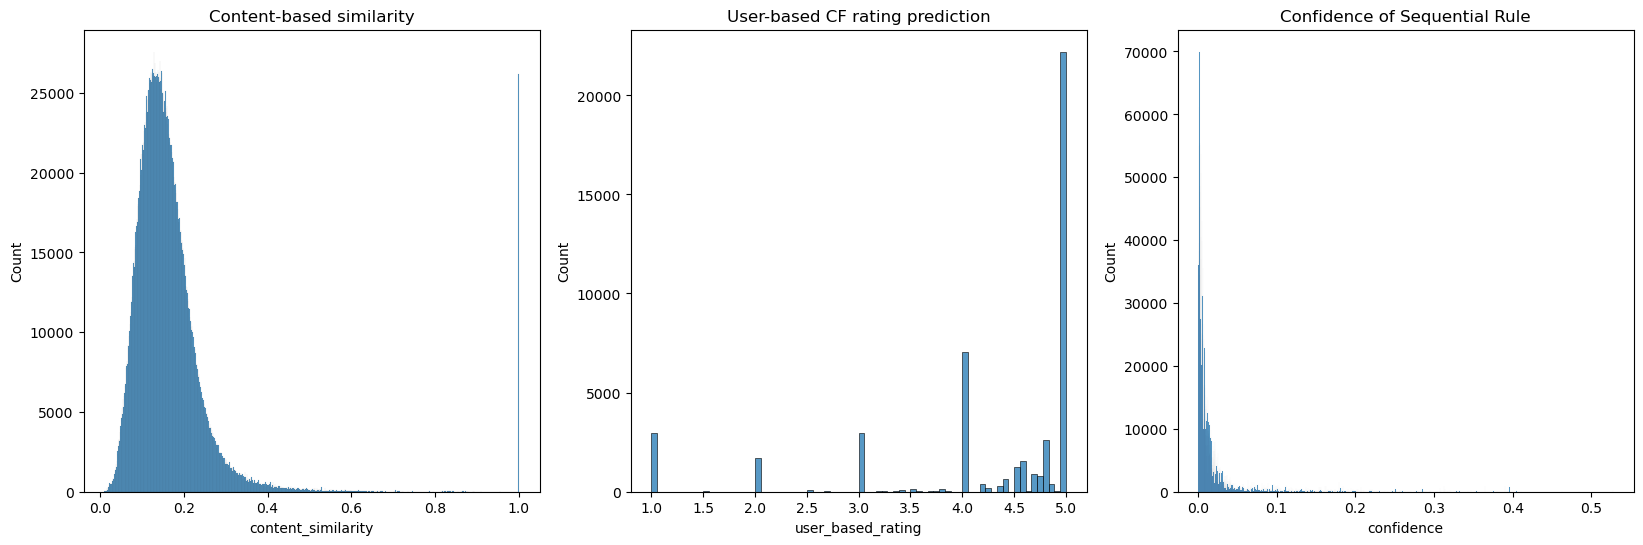

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(scores_content['content_similarity'], ax=axs[0])
axs[0].set_title('Content-based similarity')
sns.histplot(scores_user_cf['user_based_rating'], ax=axs[1])
axs[1].set_title('User-based CF rating prediction')
sns.histplot(scores_sequential['confidence'], ax=axs[2])
axs[2].set_title('Confidence of Sequential Rule')

In [24]:
# normalize
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler()
scores_content['content_similarity_scaled'] = mmscaler.fit_transform(scores_content['content_similarity'].values.reshape(-1, 1))[:, 0]
scores_user_cf['user_based_rating_scaled'] = mmscaler.fit_transform(scores_user_cf['user_based_rating'].values.reshape(-1, 1))[:, 0]
scores_sequential['confidence_scaled'] = mmscaler.fit_transform(np.log(scores_sequential['confidence']).values.reshape(-1, 1))[:, 0]

Text(0.5, 1.0, 'Confidence of Sequential Rule (scaled)')

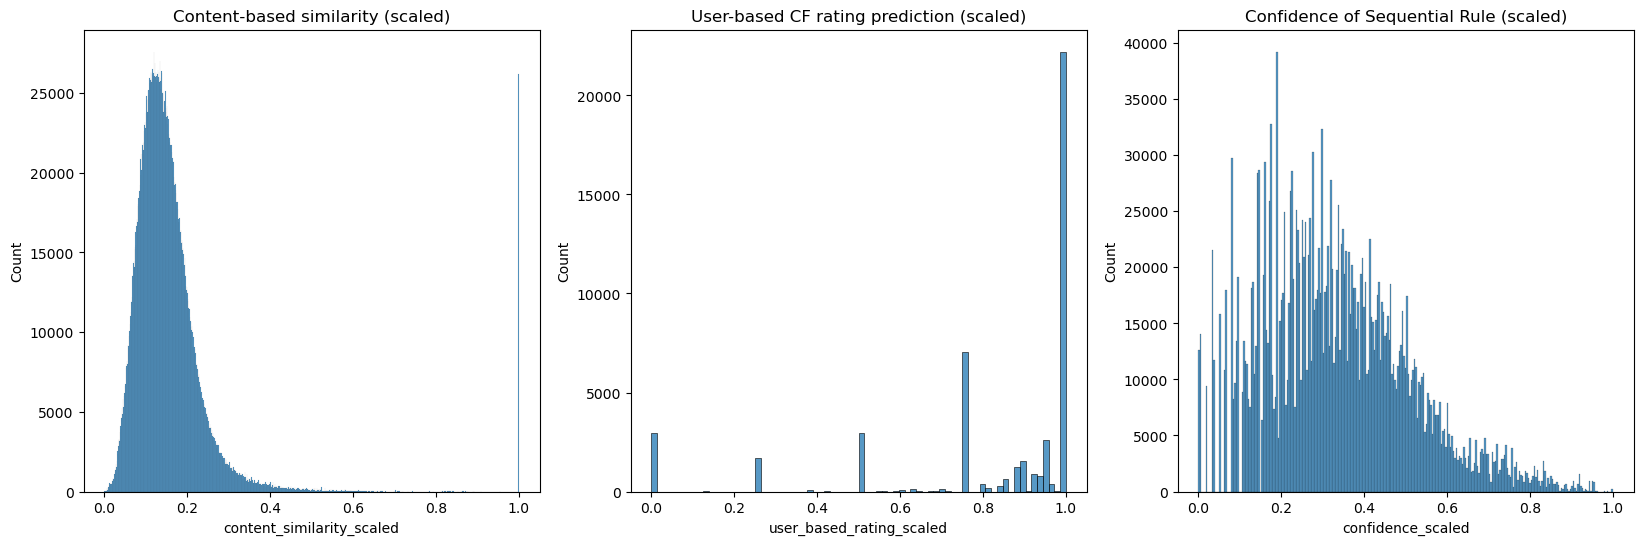

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(scores_content['content_similarity_scaled'], ax=axs[0])
axs[0].set_title('Content-based similarity (scaled)')
sns.histplot(scores_user_cf['user_based_rating_scaled'], ax=axs[1])
axs[1].set_title('User-based CF rating prediction (scaled)')
sns.histplot(scores_sequential['confidence_scaled'], ax=axs[2])
axs[2].set_title('Confidence of Sequential Rule (scaled)')

In [28]:
df_hybrid = scores_content[['user', 'course', 'content_similarity_scaled']].merge(
    scores_user_cf[['user', 'course', 'user_based_rating_scaled']], how='left', on=['user', 'course']
).merge(
    scores_sequential[['user', 'course', 'confidence_scaled']], how='left', on=['user', 'course']
).fillna(0)

df_hybrid.head()

,user,course,content_similarity_scaled,user_based_rating_scaled,confidence_scaled
0,By Benedict N,the-science-of-well-being,0.111513,0.0,0.719130
1,By Jayesh K,the-science-of-well-being,0.178291,0.0,0.670979
2,By Fabio G B,the-science-of-well-being,0.128464,0.0,0.766212
3,By Kamran B,the-science-of-well-being,0.093670,0.0,0.792102
4,By Angelica L,the-science-of-well-being,0.104375,0.0,0.789361


In [30]:
df_hybrid['hybrid_score'] = (df_hybrid['content_similarity_scaled'] + df_hybrid['user_based_rating_scaled'] + df_hybrid['confidence_scaled']) / 3

In [33]:
df_hybrid = df_hybrid.sort_values(by='hybrid_score', ascending=False)

In [35]:
k = 5
users = 0
hits = 0
precs = 0
f1scores = 0

for (user, prev_courses), next_course in tqdm(zip(test_Xseq, test_yseq), total=len(test_Xseq)):
    users += 1
    pred_courses = set(df_hybrid[df_hybrid.user == user].head(5)['course'].values)
    next_courses_set = set(next_course)
    precision = (len(pred_courses & next_courses_set) / max(len(pred_courses), 1))
    recall = (len(pred_courses & next_courses_set) / max(len(next_course), 1))

    precs += precision
    if precision + recall > 0:
        f1scores += (2 * (precision * recall) / (precision + recall))
    if precision > 0:
        hits += 1

100%|███████████████████████████████████████████████████████████████████████████████| 7680/7680 [17:36<00:00,  7.27it/s]


In [37]:
k = 10
hits10 = 0
precs10 = 0
f1scores10 = 0

for (user, prev_courses), next_course in tqdm(zip(test_Xseq, test_yseq), total=len(test_Xseq)):
    pred_courses = set(df_hybrid[df_hybrid.user == user].head(k)['course'].values)
    next_courses_set = set(next_course)
    precision = (len(pred_courses & next_courses_set) / max(len(pred_courses), 1))
    recall = (len(pred_courses & next_courses_set) / max(len(next_course), 1))

    precs10 += precision
    if precision + recall > 0:
        f1scores10 += (2 * (precision * recall) / (precision + recall))
    if precision > 0:
        hits10 += 1

100%|███████████████████████████████████████████████████████████████████████████████| 7680/7680 [17:41<00:00,  7.24it/s]


In [38]:
print(f"    | Hit rate | Precision | F1 Score")
print(f"@5  | {hits / users:.3f}    | {precs / users:.3f}     | {f1scores / users:.3f}   ")
print(f"@10 | {hits10 / users:.3f}    | {precs10 / users:.3f}     | {f1scores10 / users:.3f}   ")

    | Hit rate | Precision | F1 Score
@5  | 0.181    | 0.038     | 0.058   
@10 | 0.377    | 0.045     | 0.072   
